In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [138]:
df=pd.read_csv('D:/New Volume (D)/Đại học/Data/Data.csv')
df=df.drop('Unnamed: 0',axis='columns')
df.head()

,product_id,product_name,variation,category_id,brand,rating,initial_price,final_price,currency,sold,status,image,flash_sale,vouchers,category,price_to_sold_ratio
0,11821464825,oralb io series 9 electric toothbrush with mic...,No variation,100001,ORALB,4.9,517.3,317.5,USD,363,Available in stock,"[""https://down-sg.img.susercontent.com/file/sg...",False,"[{""claimable"":false,""currency"":""SGD"",""discount...",Daily Life,0.872253
1,28005508734,bundle of 4 blood sanitary pad made with 100 corn,pad25 x2pad 29 x2,100001,BLOOD,5.0,13.4,10.7,USD,11487,Available in stock,"[""https://down-my.img.susercontent.com/file/my...",False,"[{""claimable"":false,""currency"":""MYR"",""discount...",Daily Life,0.000931
2,16399611463,earplug for sleeping dustproof silicone earplu...,black,100001,UNKNOWN,4.6,7.5,7.5,USD,39996,Available in stock,"[""https://down-cl.img.susercontent.com/file/sg...",False,"[{""claimable"":false,""currency"":""CLP"",""discount...",Daily Life,0.000188
3,19786204500,omilay tokyo apple cider vinegar gummies slimm...,biotin gummies,100001,OMILAY,4.8,53.1,53.1,USD,34480151,Available in stock,"[""https://down-ph.img.susercontent.com/file/ph...",False,"[{""claimable"":false,""currency"":""PHP"",""discount...",Daily Life,0.000002
4,27700989315,powerman obat kuat pria tahan lama herbal kaps...,No variation,100001,POWER MAN,4.8,7.8,7.8,USD,3420,Available in stock,"[""https://down-id.img.susercontent.com/file/id...",False,"[{""claimable"":false,""currency"":""IDR"",""discount...",Daily Life,0.002280


In [204]:
df = df.drop(columns=["brand"])
df = df.drop(columns=["category"])

In [205]:
#ord_cols
ord_cols = ["brand", "category"]

#num_cols
num_cols = ["initial_price", "final_price", "price_to_sold_ratio"]
ingredients = df.columns.to_list()[:-12]
for ing in ingredients:
    num_cols.append(ing)

In [206]:
ordinal_transformer = Pipeline(steps = [
    ('ordimputer', SimpleImputer(strategy = 'most_frequent')),
    ('target_enc', TargetEncoder()),
    ("scaler", StandardScaler())])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ord_cols),
        ("num", numeric_transformer, num_cols),
    ]
)

In [ ]:
y = df_ing["final_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [207]:
# determine baseline error
mae_train = mean_absolute_error(y_train, np.ones([y_train.shape[0],])* y_train.median())
mae_test = mean_absolute_error(y_test, np.ones([y_test.shape[0],])* y_train.median())

print("MAE")
print(f"train: {mae_train:.3f}") 
print(f"test: {mae_test:.3f}")

MAE
train: 33.223
test: 25.463


In [208]:
# instantiate, fit and run model
X_train_ct = preprocessor.fit_transform(X_train, y_train)
boost = XGBRegressor()
boost.fit(X_train_ct, y_train)
pred_train_boost = boost.predict(X_train_ct)

X_test_ct = preprocessor.transform(X_test)
pred_test_boost = boost.predict(X_test_ct)

In [209]:
# determine error
mae_train = mean_absolute_error(y_train, pred_train_boost)
mae_test = mean_absolute_error(y_test, pred_test_boost)

print("MAE: ")
print(f"train: {mae_train:.3f}")
print(f"test: {mae_test: .3f}")

MAE: 
train: 0.038
test:  2.565


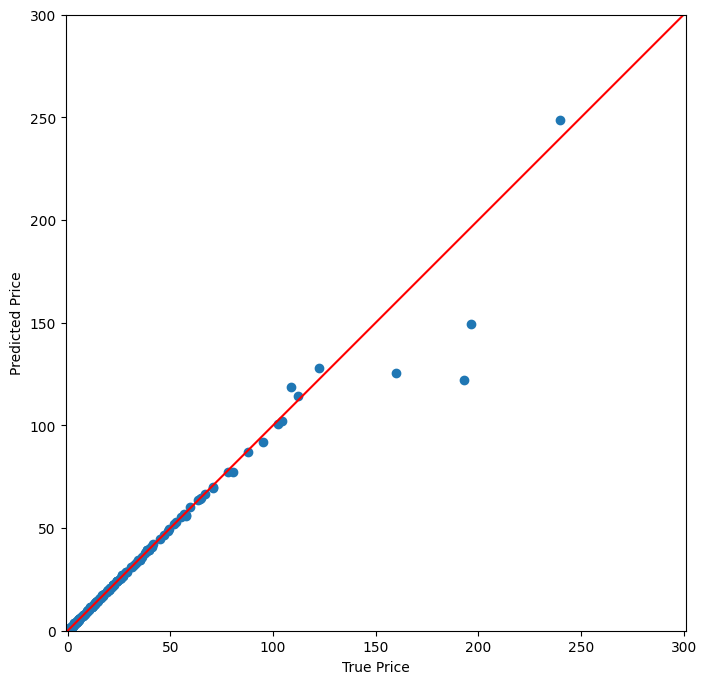

In [210]:
# plot predictions against true prices
plt.figure(figsize=(8,8))
plt.scatter(y_test, pred_test_boost)
plt.plot([0,300],[0,300],color="r")
plt.axis("Equal")
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.show()

In [211]:
# parameter grid
param_grid = {
    "learning_rate": [0.03, 0.05, 0.07],
    "n_estimators": [500, 750, 1000],
    "max_depth": [5, 7, 9]
}


# instantiate and fit
boost = XGBRegressor()
grid_search = GridSearchCV(boost, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train_ct, y_train)

# return best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# get predictions off best model
best_boost = grid_search.best_estimator_
pred_test_boost_gs = best_boost.predict(X_test_ct)

Best parameters: {'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 500}
Best score: -7.924909479383904


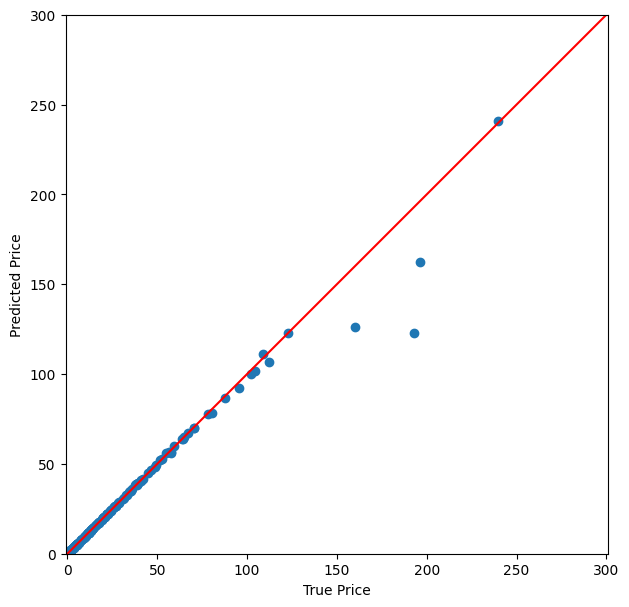

In [212]:
# plot predictions against true prices
plt.figure(figsize=(7,7))
plt.scatter(y_test, pred_test_boost_gs)
plt.plot([0,300],[0,300],color="r")
plt.axis("Equal")
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.show()

In [213]:
boost = XGBRegressor()
rf = RandomForestRegressor()
ridge = Ridge()
lasso = Lasso()
svr = SVR(kernel='linear')

stack = StackingCVRegressor(regressors=(boost, rf, ridge, lasso, svr),
                            meta_regressor=boost, cv=5,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42)

stack.fit(X_train_ct, y_train)
pred_stack = stack.predict(X_test_ct)
mae_test = mean_absolute_error(y_test, pred_stack)

print("MAE: ")
print(f"test: {mae_test: .3f}")

MAE: 
test:  2.223


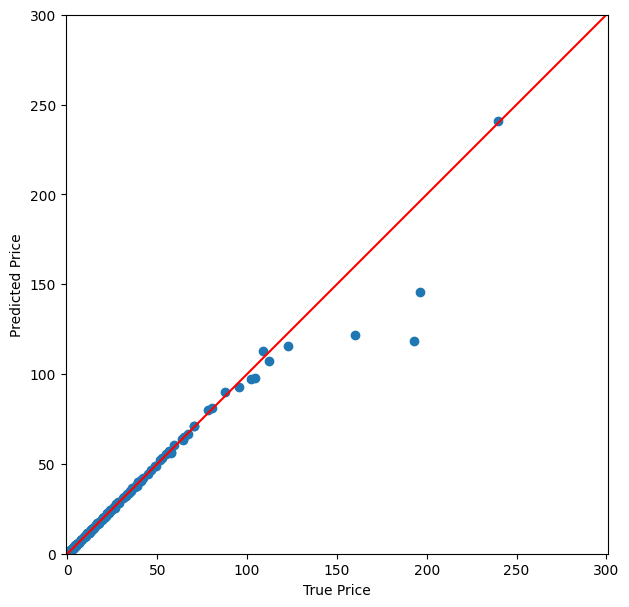

In [214]:
# plot predictions against true prices
plt.figure(figsize=(7,7))
plt.scatter(y_test, pred_stack)
plt.plot([0,300],[0,300],color="r")
plt.axis("Equal")
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.show()

In [221]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

# Đảm bảo dữ liệu đầu vào là NumPy array
X_train_ct = np.array(preprocessor.fit_transform(X_train, y_train))
X_test_ct = np.array(preprocessor.transform(X_test))
y_train = np.array(y_train)

# Kiểm tra kích thước
print("X_train_ct shape:", X_train_ct.shape)
print("y_train shape:", y_train.shape)

# Định nghĩa mô hình
learning_rate = 0.01
model4 = Sequential([
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
])

# Compile mô hình
model4.compile(
    loss=MeanAbsoluteError(),
    optimizer=Adam(learning_rate=learning_rate),
    metrics=[MeanAbsoluteError()]
)

# Huấn luyện
model_4 = model4.fit(
    X_train_ct, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2
)


X_train_ct shape: (718, 6)
y_train shape: (718,)
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 37.3385 - mean_absolute_error: 37.3374 - val_loss: 11.9312 - val_mean_absolute_error: 10.8663
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.1498 - mean_absolute_error: 19.1473 - val_loss: 6.4714 - val_mean_absolute_error: 6.1521
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 11.1908 - mean_absolute_error: 11.1965 - val_loss: 12.3576 - val_mean_absolute_error: 11.6647
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.2540 - mean_absolute_error: 18.2477 - val_loss: 4.6106 - val_mean_absolute_error: 4.6619
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.1858 - mean_absolute_error: 9.1861 - val_loss: 5.6242 - val_mean_absolute_error: 6.0684
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.8009 - mean_absolute_error: 11.8012 - val_loss: 10.6927 - val_mean_absolute_error: 10.1543
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

In [222]:
y_train_pred = model4.predict(X_train_ct)
y_test_pred = model4.predict(X_test_ct)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MAE: ")
print(f"train: {mae_train:.3f}")
print(f"test: {mae_test: .3f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE: 
train: 1.948
test:  1.602


In [223]:
learning_rate = 0.01

model5 = Sequential([
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

mae_k = MeanAbsoluteError()
model5.compile(loss=mae_k, optimizer=Adam(learning_rate=learning_rate), metrics=[mae_k])

model_5 = model5.fit(X_train_ct, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 56.5692 - mean_absolute_error: 56.5639 - val_loss: 23.6553 - val_mean_absolute_error: 23.7434
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 40.5481 - mean_absolute_error: 40.5430 - val_loss: 17.5524 - val_mean_absolute_error: 17.4035
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 19.6853 - mean_absolute_error: 19.6828 - val_loss: 13.0258 - val_mean_absolute_error: 12.0258
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 29.1645 - mean_absolute_error: 29.1726 - val_loss: 16.1677 - val_mean_absolute_error: 15.8260
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 29.3099 - mean_absolute_error: 29.3124 - val_loss: 13.6367 - val_mean_absolute_error: 13.7771
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.9464 - mean_absolute_error: 21.9441 - val_loss: 15.2078 - val_mean_absolute_error: 14.8792
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 17.5658 - mean_absolute_error:

In [224]:
y_train_pred = model5.predict(X_train_ct)
y_test_pred = model5.predict(X_test_ct)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MAE: ")
print(f"train: {mae_train:.3f}")
print(f"test: {mae_test: .3f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE: 
train: 3.909
test:  3.913


In [225]:
learning_rate = 0.01

model6 = Sequential([
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

model6.compile(loss=mae_k, optimizer=Adam(learning_rate=learning_rate), metrics=[mae_k])

model_6 = model6.fit(X_train_ct, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 43.4709 - mean_absolute_error: 43.4607 - val_loss: 16.1961 - val_mean_absolute_error: 15.0274
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 40.8098 - mean_absolute_error: 40.8116 - val_loss: 18.9401 - val_mean_absolute_error: 18.8790
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 38.9646 - mean_absolute_error: 38.9538 - val_loss: 21.1188 - val_mean_absolute_error: 21.0924
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 36.1789 - mean_absolute_error: 36.1619 - val_loss: 17.9828 - val_mean_absolute_error: 17.9333
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 33.4064 - mean_absolute_error: 33.4090 - val_loss: 19.1556 - val_mean_absolute_error: 19.0896
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 46.5243 - mean_absolute_error: 46.5092 - val_loss: 20.0577 - val_mean_absolute_error: 20.0067
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 36.9831 - mean_absolute_error:

In [226]:
y_train_pred = model6.predict(X_train_ct)
y_test_pred = model6.predict(X_test_ct)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MAE: ")
print(f"train: {mae_train:.3f}")
print(f"test: {mae_test: .3f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MAE: 
train: 35.660
test:  28.680


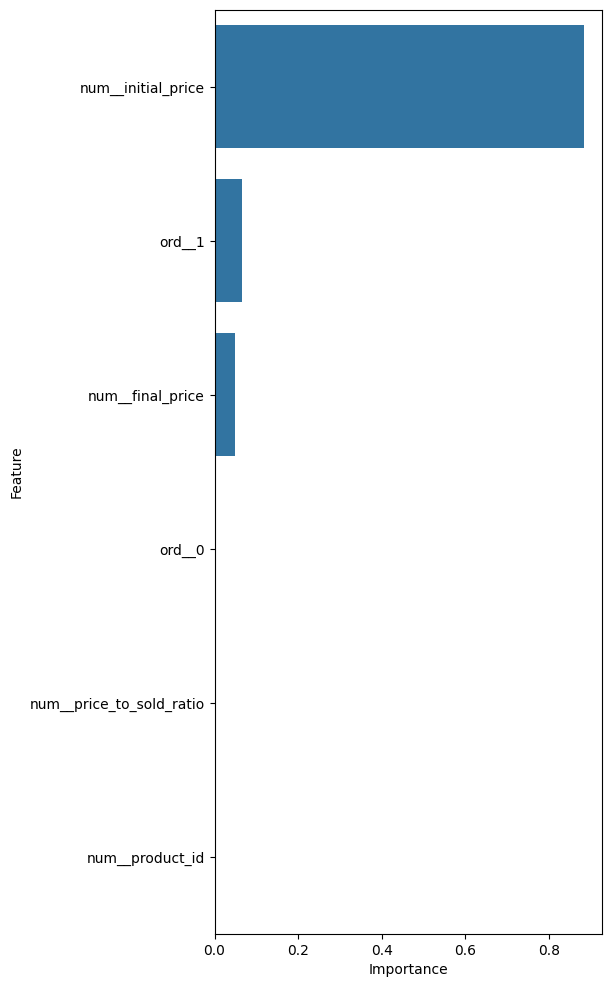

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

# Fit the model
X_train_ct = preprocessor.fit_transform(X_train, y_train)
boost = XGBRegressor()
boost.fit(X_train_ct, y_train)

# Nếu X_train_ct là một ma trận sparse, bạn có thể chuyển nó thành DataFrame
# Giả sử X_train_ct có số cột bằng số lượng đặc trưng đã biến đổi
columns = preprocessor.get_feature_names_out()  # lấy tên các đặc trưng sau biến đổi
features_df = pd.DataFrame({
    "feature": columns,
    "importance": boost.feature_importances_
})

# Sắp xếp theo độ quan trọng của các đặc trưng
features_df = features_df.sort_values("importance", ascending=False)

# Vẽ biểu đồ độ quan trọng
plt.figure(figsize=(5, 12))
sns.barplot(x="importance", y="feature", data=features_df.iloc[:15])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [241]:
df=pd.read_csv('D:/New Volume (D)/Đại học/Data/Data.csv')
df=df.drop('Unnamed: 0',axis='columns')
df.head()

,product_id,product_name,variation,category_id,brand,rating,initial_price,final_price,currency,sold,status,image,flash_sale,vouchers,category,price_to_sold_ratio
0,11821464825,oralb io series 9 electric toothbrush with mic...,No variation,100001,ORALB,4.9,517.3,317.5,USD,363,Available in stock,"[""https://down-sg.img.susercontent.com/file/sg...",False,"[{""claimable"":false,""currency"":""SGD"",""discount...",Daily Life,0.872253
1,28005508734,bundle of 4 blood sanitary pad made with 100 corn,pad25 x2pad 29 x2,100001,BLOOD,5,13.4,10.7,USD,11487,Available in stock,"[""https://down-my.img.susercontent.com/file/my...",False,"[{""claimable"":false,""currency"":""MYR"",""discount...",Daily Life,0.000931
2,16399611463,earplug for sleeping dustproof silicone earplu...,black,100001,UNKNOWN,4.6,7.5,7.5,USD,39996,Available in stock,"[""https://down-cl.img.susercontent.com/file/sg...",False,"[{""claimable"":false,""currency"":""CLP"",""discount...",Daily Life,0.000188
3,19786204500,omilay tokyo apple cider vinegar gummies slimm...,biotin gummies,100001,OMILAY,4.8,53.1,53.1,USD,34480151,Available in stock,"[""https://down-ph.img.susercontent.com/file/ph...",False,"[{""claimable"":false,""currency"":""PHP"",""discount...",Daily Life,0.000002
4,27700989315,powerman obat kuat pria tahan lama herbal kaps...,No variation,100001,POWER MAN,4.8,7.8,7.8,USD,3420,Available in stock,"[""https://down-id.img.susercontent.com/file/id...",False,"[{""claimable"":false,""currency"":""IDR"",""discount...",Daily Life,0.002280


In [243]:
# create dataframe of prices and predictions
df_prices = df.loc[y_test.index.to_list()]
df_prices = df_prices[["product_name", "category", "brand"]]
df_prices["real_price"] = y_test
df_prices["predicted_price"] = pred_test_boost
df_prices["difference"] = (df_prices["real_price"] - df_prices["predicted_price"]).round(2)



In [244]:
# find most overpriced brands
overpriced = df_prices.loc[df_prices["difference"] > 20]
overpriced.brand.value_counts().head(10)

brand
UNKNOWN      1
YEBISU       1
FREEDCONN    1
XIAOMI       1
TP LINK      1
Name: count, dtype: int64

In [245]:
# find most underpriced brands
underpriced = df_prices.loc[df_prices["difference"] < 0]
underpriced.brand.value_counts().head(10)

brand
UNKNOWN       67
LG             2
GOOD TASTE     1
LUX            1
TORAY          1
AIRWALK        1
RAMIRO         1
WMUNCC         1
Name: count, dtype: int64

In [248]:
# remove non-essential columns
from sklearn.neighbors import NearestNeighbors

features = df.copy()
features = features.drop(columns = ["product_name", "rating", "initial_price", "final_price", "brand", "sold", 
                        "price_to_sold_ratio"])
features = pd.get_dummies(features)

# fit KNN model
model = NearestNeighbors(n_neighbors=2, algorithm='ball_tree')
model.fit(features)
dist, idlist = model.kneighbors(features)

In [250]:
# define function
def SuperDuper(product_name):
    product_list = []
    product_id = df_ing[df_ing["product_names"] == product_name].index
    product_id = product_id[0]
    product_price = df_ing["price"].iloc[product_id] 
    for newid in idlist[product_id]:
        name = df_ing.loc[newid].product_names
        brand = df_ing.loc[newid].brand
        price = df_ing.loc[newid].price
        price_diff = product_price - price
        if name == product_name:
            pass
        elif price < product_price:
            product_list.append(f"{name} from {brand}, ${price: .2f}, saving ${price_diff: .2f}")
        
    return product_list   

In [252]:
# creating dataframes and pickles for SuperDuper streamlit app
products_data = df[["brand", "product_name","initial_price","final_price"]]
products_data.to_csv(r"products_data.csv")
features.to_pickle("./features.pkl")